# Evaluation of XGBoost GEDI -> S1S2 Regression Model

Having successfully ingested GEDI L4A and collocated Sentinel statistical data into a spatiotemporal database, energies now focussed on training a random model regressor to predict wall-to-wall maps of GEDI-estimated Aboveground Biomass Density. Using the functional firepower of PostgreSQL and PostGIS, aggregated subsets of collocated GEDI and Sentinel-based metrics were extracted from the spatiotemporal database as a source of training and test data. 

__Important Note:__ Statistics related to [S2 cloudless mask](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/) were retrieved from Sentinel-Hub and ingested into the Sentinel-2 data tables - records were therefore filtered based on presence of cloud contamination affecting multispectral statistic calculations.

### Load and filter GEDI + Sentinel SAR and multispectral metrics from CSV file

In [1]:
import pandas as pd

# load sql dump dataset
df = pd.read_csv("result.csv" )
df.columns

Index(['shot_number', 'datetime', 'ndvi_mean', 'ndvi_stdev', 'evi_mean',
       'evi_stdev', 'gndvi_mean', 'gndvi_stdev', 'ndci_mean', 'ndci_stdev',
       'mcari_mean', 'mcari_stdev', 'lai_mean', 'lai_stdev', 'fapar_mean',
       'fapar_stdev', 'fcover_mean', 'fcover_stdev', 'ccc_mean', 'ccc_stdev',
       'cab_mean', 'cab_stdev', 'vv_mean', 'vv_stdev', 'vh_mean', 'vh_stdev',
       'rvi_mean', 'rvi_stdev', 'agbd', 'agbd_se', 'agbd_t', 'agbd_t_se',
       'solar_elevation', 'landsat_treecover', 'urban_proportion', 'doy',
       'geometry'],
      dtype='object')

In [2]:
# filter out high value agbd outliers
names = [ col for col in df.columns if 'stdev' in col or 'mean' in col ]
names.extend( [ 'agbd', 'geometry' ] )

df = df[ names ]
df = df[ ~df.isnull().any(axis=1)]
df = df[ df[ 'agbd'] < 150 ]
df.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,cab_mean,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev,agbd,geometry
0,0.700942,0.022761,0.385406,0.029489,0.640763,0.021618,0.350797,0.038914,0.076101,0.013943,...,0.245258,0.024980,-19.846854,5.086426,-33.643522,6.018051,0.763801,0.299126,14.524839,0101000020E6100000C8832CEBF029424062824CA2B61D...
1,0.792495,0.022460,0.474953,0.046559,0.659773,0.019672,0.481831,0.041600,0.148157,0.028050,...,0.284223,0.022613,-17.114902,5.383106,-32.145597,5.797591,0.709572,0.316643,44.135746,0101000020E6100000F6A567CC88F94140E109F88D85F4...
2,0.812853,0.010816,0.512549,0.032435,0.711490,0.013880,0.418403,0.025297,0.093650,0.010317,...,0.468902,0.050516,-20.339635,4.839698,-36.827165,5.451400,0.632571,0.279426,11.720868,0101000020E6100000C23831B286FC4140E076A81A43E4...
3,0.594918,0.085698,0.457408,0.068172,0.560783,0.069048,0.243520,0.101802,0.068779,0.034893,...,0.224884,0.058007,-17.118237,4.974140,-34.875348,6.167691,0.608235,0.271688,28.395636,0101000020E61000002E7E896147FD41407D2B9FB1689F...
4,0.838596,0.013846,0.575828,0.033907,0.728137,0.014577,0.523182,0.025724,0.179724,0.023041,...,0.382011,0.023092,-16.777815,6.201166,-32.588168,6.036422,0.662434,0.277331,45.124439,0101000020E61000005B9A4BFD57FB4140739C528A2EA1...


### Transpose into GeoDataFrame in preparation for spatial aggregation

In [3]:
import geopandas as gpd
from shapely import wkb

# convert wkb geometries into shapely point objects in geographic crs
df['geometry'] = df['geometry'].apply( wkb.loads, hex=True )
gdf = gpd.GeoDataFrame( df, geometry='geometry', crs='epsg:4326' )

In [4]:
gdf.total_bounds

array([35.41428939, -1.30904186, 37.39445352,  0.86672992])

In [5]:
# subset - optional - and reproject to pseudo mercator
gdf = gdf.cx[ 36:37, -1.0:0.0 ]
gdf = gdf.to_crs( 3857 )
gdf

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,cab_mean,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev,agbd,geometry
5,0.703844,0.126092,0.478367,0.083934,0.625220,0.099869,0.352568,0.136470,0.106567,0.046394,...,0.273409,0.068731,-16.789793,6.573246,-31.141243,7.375716,0.724613,0.274022,33.481136,POINT (4027250.592 -28505.352)
6,0.538172,0.110581,0.331756,0.078718,0.528796,0.084141,0.210847,0.105044,0.050255,0.033306,...,0.168576,0.029948,-16.447015,4.715249,-33.349992,6.321745,0.614979,0.266217,39.748623,POINT (4027815.948 -27706.540)
7,0.721165,0.095390,0.480787,0.088781,0.638491,0.044071,0.406486,0.088259,0.133251,0.041848,...,0.247577,0.052927,-19.838569,4.767821,-33.409679,5.078786,0.757707,0.275219,42.047935,POINT (4029280.554 -25639.231)
8,0.761984,0.015798,0.445775,0.019053,0.673856,0.012678,0.405966,0.031708,0.096741,0.012475,...,0.290771,0.014349,-18.649091,5.387882,-30.953713,6.725656,0.834939,0.317763,31.245541,POINT (4014638.979 -47547.382)
10,0.683522,0.083404,0.463039,0.072039,0.618075,0.056069,0.316305,0.081059,0.085173,0.030239,...,0.266477,0.059736,-16.638738,4.538076,-33.450208,5.419240,0.624593,0.291090,34.876263,POINT (4028703.764 -27552.024)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365391,0.678777,0.097442,0.468340,0.094194,0.610856,0.075198,0.322541,0.091746,0.094854,0.040442,...,0.249975,0.062299,-17.509971,4.662346,-31.700208,5.301707,0.741132,0.304221,12.217358,POINT (4077715.896 -108135.588)
365392,0.731789,0.056356,0.527179,0.070904,0.646839,0.028718,0.386015,0.055529,0.130496,0.030615,...,0.278400,0.037938,-20.464444,5.111924,-35.001158,4.876951,0.719111,0.296111,11.206178,POINT (4078509.495 -109260.742)
365393,0.632920,0.118437,0.463520,0.123632,0.586443,0.061789,0.321140,0.086064,0.114349,0.044064,...,0.211903,0.061970,-18.122595,4.869540,-35.249933,5.442144,0.615971,0.288937,10.608393,POINT (4078707.913 -109542.070)
365394,0.808099,0.057161,0.618867,0.080170,0.720803,0.053816,0.470851,0.084332,0.172249,0.047673,...,0.438445,0.101908,-19.811485,5.039499,-33.070762,5.591280,0.775102,0.280469,26.403378,POINT (4079767.222 -111041.724)


<AxesSubplot:ylabel='Frequency'>

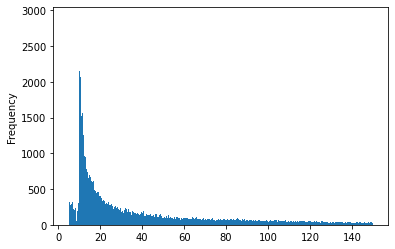

In [6]:
# plot agbd distribution
gdf[ 'agbd' ].plot.hist(bins=1000)

### Generate regular grid encapsulating extent of GEDI / Sentinel sample data

In [7]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf.total_bounds
gdf.total_bounds

array([ 4.00750185e+06, -1.11324885e+05,  4.11881951e+06, -3.55920011e-01])

In [8]:
import numpy as np
import shapely

cell_size = 1000

# generate grid of nominated cell size in metres
cells = []
for x0 in np.arange( xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange( ymin, ymax+cell_size, cell_size):
        
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        
        cells.append( shapely.geometry.box(x0, y0, x1, y1) )        

In [9]:
# create dataframe comprising grid cell polygons
grid = gpd.GeoDataFrame( cells, crs='epsg:3857', columns=['geometry'] )
grid.head(5)

,geometry
0,"POLYGON ((4006501.849 -111324.885, 4006501.849..."
1,"POLYGON ((4006501.849 -110324.885, 4006501.849..."
2,"POLYGON ((4006501.849 -109324.885, 4006501.849..."
3,"POLYGON ((4006501.849 -108324.885, 4006501.849..."
4,"POLYGON ((4006501.849 -107324.885, 4006501.849..."


### Visualise grid superimposed over colour-coded GEDI-based AGBD estimates

(-57824.88541858853, -51824.88541858853)

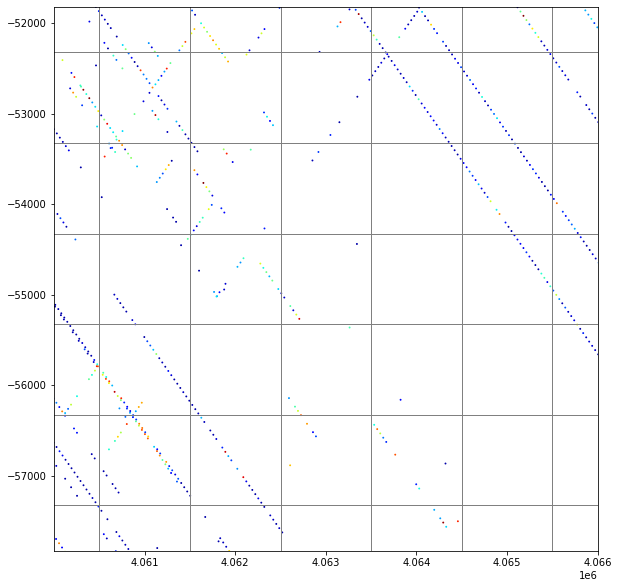

In [10]:
import matplotlib.pyplot as plt

# plot points overlaid by grid
ax = gdf.plot(markersize=.8, figsize=(20, 10), column='agbd', cmap='jet')
plt.autoscale(False)
grid.plot(ax=ax, aspect=1, facecolor="none", edgecolor='grey')

xc, yc = grid.dissolve().centroid.x.values[0], grid.dissolve().centroid.y.values[0]

plt.xlim( [ xc - 3000, xc + 3000 ] )
plt.ylim( [ yc - 3000, yc + 3000 ] )

### Compute spatially aggregated GEDI-Sentinel parameter values within each grid cell 

In [11]:
# merge dataframes to assign GEDI-Sentinel point geometries to corresponding grid cell
merge = gpd.sjoin( gdf, grid, how='left', predicate='within' )
merge.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev,agbd,geometry,index_right
5,0.703844,0.126092,0.478367,0.083934,0.625220,0.099869,0.352568,0.136470,0.106567,0.046394,...,0.068731,-16.789793,6.573246,-31.141243,7.375716,0.724613,0.274022,33.481136,POINT (4027250.592 -28505.352),2342.0
6,0.538172,0.110581,0.331756,0.078718,0.528796,0.084141,0.210847,0.105044,0.050255,0.033306,...,0.029948,-16.447015,4.715249,-33.349992,6.321745,0.614979,0.266217,39.748623,POINT (4027815.948 -27706.540),2456.0
7,0.721165,0.095390,0.480787,0.088781,0.638491,0.044071,0.406486,0.088259,0.133251,0.041848,...,0.052927,-19.838569,4.767821,-33.409679,5.078786,0.757707,0.275219,42.047935,POINT (4029280.554 -25639.231),2571.0
8,0.761984,0.015798,0.445775,0.019053,0.673856,0.012678,0.405966,0.031708,0.096741,0.012475,...,0.014349,-18.649091,5.387882,-30.953713,6.725656,0.834939,0.317763,31.245541,POINT (4014638.979 -47547.382),967.0
10,0.683522,0.083404,0.463039,0.072039,0.618075,0.056069,0.316305,0.081059,0.085173,0.030239,...,0.059736,-16.638738,4.538076,-33.450208,5.419240,0.624593,0.291090,34.876263,POINT (4028703.764 -27552.024),2569.0


In [12]:
# compute median GEDI-Sentinel point by dissolving on spatial join index
agg = merge.dissolve(by="index_right", aggfunc='median')
agg.head(5)

,geometry,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,...,ccc_stdev,cab_mean,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev,agbd
index_right,,,,,,,,,,,,,,,,,,,,,
149.0,"MULTIPOINT (4007527.658 -74359.168, 4007560.67...",0.653781,0.050974,0.511954,0.070145,0.600002,0.029820,0.310053,0.050608,0.109701,...,30.707403,0.223238,0.036371,-29.258740,5.654269,-47.029277,10.560695,0.674185,0.326606,10.365868
150.0,"MULTIPOINT (4007631.235 -73803.402, 4007642.89...",0.412857,0.053095,0.245082,0.040993,0.489377,0.032863,0.164664,0.042645,0.035739,...,6.338284,0.095330,0.015622,-28.732869,5.161262,-48.236176,10.006928,0.582469,0.324883,11.120900
152.0,"MULTIPOINT (4008229.268 -72082.599, 4008275.53...",0.538207,0.081438,0.252474,0.067000,0.539025,0.040751,0.254991,0.068396,0.049678,...,20.513419,0.140386,0.032633,-19.622541,4.700172,-37.764227,7.214614,0.603510,0.266249,9.164226
153.0,"MULTIPOINT (4007516.214 -71174.230, 4007995.95...",0.504221,0.064161,0.264248,0.043860,0.547301,0.034380,0.209771,0.045209,0.043497,...,8.512029,0.127804,0.019940,-23.456359,5.191030,-39.379788,7.372887,0.723840,0.318810,11.422557
154.0,"MULTIPOINT (4007560.852 -70099.123, 4007594.22...",0.560844,0.067549,0.308647,0.059176,0.575276,0.037940,0.245378,0.057474,0.054355,...,13.962177,0.161715,0.024384,-22.804217,5.558024,-37.443904,7.328329,0.680487,0.303212,10.481143


In [13]:
# compute number of GEDI-Sentinel points per grid cell by dissolving on spatial join index
count = merge.dissolve( by="index_right", aggfunc='count')
count.head(5)

,geometry,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,...,ccc_stdev,cab_mean,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev,agbd
index_right,,,,,,,,,,,,,,,,,,,,,
149.0,"MULTIPOINT (4007527.658 -74359.168, 4007560.67...",10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
150.0,"MULTIPOINT (4007631.235 -73803.402, 4007642.89...",18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
152.0,"MULTIPOINT (4008229.268 -72082.599, 4008275.53...",5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
153.0,"MULTIPOINT (4007516.214 -71174.230, 4007995.95...",8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
154.0,"MULTIPOINT (4007560.852 -70099.123, 4007594.22...",12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


In [14]:
# combine median + count spatial aggregations
data = agg.copy().reset_index( drop=True).copy()
data[ 'count'] = count[ 'agbd' ].values 

# apply minimum count condition to sample data
data = data[ data[ 'count'] > 2 ].drop( [ 'count', 'geometry' ], axis=1 )
data

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,ccc_stdev,cab_mean,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev,agbd
0,0.653781,0.050974,0.511954,0.070145,0.600002,0.029820,0.310053,0.050608,0.109701,0.026049,...,30.707403,0.223238,0.036371,-29.258740,5.654269,-47.029277,10.560695,0.674185,0.326606,10.365868
1,0.412857,0.053095,0.245082,0.040993,0.489377,0.032863,0.164664,0.042645,0.035739,0.013383,...,6.338284,0.095330,0.015622,-28.732869,5.161262,-48.236176,10.006928,0.582469,0.324883,11.120900
2,0.538207,0.081438,0.252474,0.067000,0.539025,0.040751,0.254991,0.068396,0.049678,0.023493,...,20.513419,0.140386,0.032633,-19.622541,4.700172,-37.764227,7.214614,0.603510,0.266249,9.164226
3,0.504221,0.064161,0.264248,0.043860,0.547301,0.034380,0.209771,0.045209,0.043497,0.014623,...,8.512029,0.127804,0.019940,-23.456359,5.191030,-39.379788,7.372887,0.723840,0.318810,11.422557
4,0.560844,0.067549,0.308647,0.059176,0.575276,0.037940,0.245378,0.057474,0.054355,0.020260,...,13.962177,0.161715,0.024384,-22.804217,5.558024,-37.443904,7.328329,0.680487,0.303212,10.481143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8032,0.614321,0.049962,0.494256,0.041462,0.518082,0.037365,0.305665,0.054035,0.109322,0.026789,...,19.281390,0.187064,0.030280,-20.566540,4.704336,-35.241719,5.950096,0.709719,0.286748,20.830180
8034,0.757151,0.037490,0.515485,0.050174,0.646461,0.025868,0.415859,0.051029,0.130291,0.027273,...,25.188810,0.285209,0.027907,-19.365386,5.485883,-33.977804,6.059157,0.716890,0.302620,19.232078
8035,0.593145,0.074381,0.473935,0.086556,0.538128,0.042066,0.265602,0.058946,0.081966,0.031477,...,39.366367,0.187863,0.050027,-23.892557,5.178896,-34.842893,6.019674,0.883000,0.304914,19.706699
8042,0.527634,0.082115,0.317582,0.061817,0.549847,0.050530,0.228533,0.073050,0.057750,0.025547,...,19.811872,0.151535,0.032566,-24.096758,5.376746,-38.376189,5.616188,0.760084,0.311785,22.566043


### Visualise collinearity between spatially aggregated GEDI / Sentinel parameter values

<AxesSubplot:>

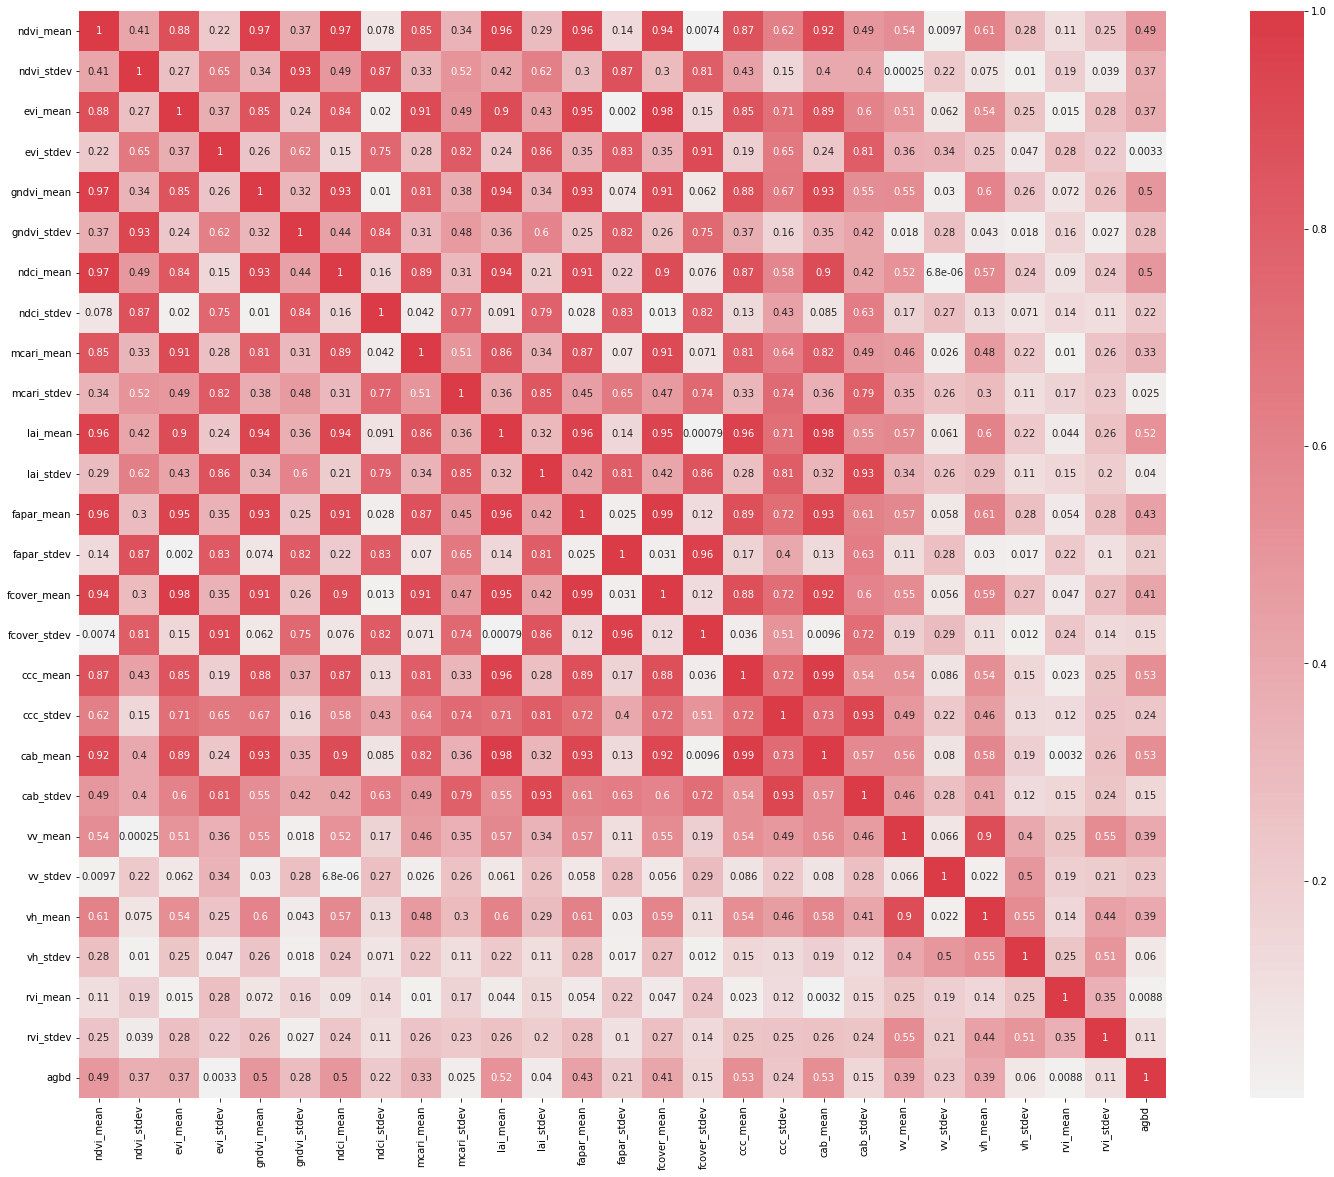

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot correlation matrix
plt.figure( figsize=(30,20) )
cmap = sns.diverging_palette( 500, 10, as_cmap=True )
sns.heatmap( data.corr().abs(), cmap=cmap, center=0, square=True, annot=True )

### Visualise distribution of Sentinel-1 and Sentinel-2 predictor variables

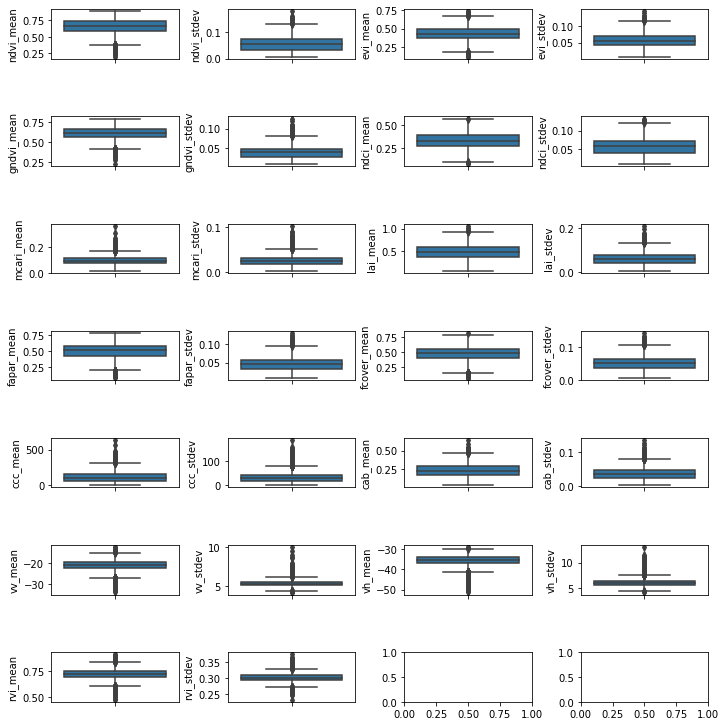

In [16]:
cols = [ col for col in data.columns if 'mean' in col or 'stdev' in col ]

# visualise feature variable distributions using boxplot diagrams
def getBoxPlots( df ):
        
    fig, axs = plt.subplots( ncols=4, nrows=int( len(cols)/4 ) + 1, figsize=(10,10))
    index = 0
    axs= axs.flatten()

    for col in cols:
            sns.boxplot( y=col, data=df, ax=axs[ index ] )
            index += 1

    plt.tight_layout( pad=0.4, w_pad=0.5, h_pad=5.0)
    
getBoxPlots( data )

### Filter outliers by removing records where predictor variable outside 3 stdev range 

7124 5368


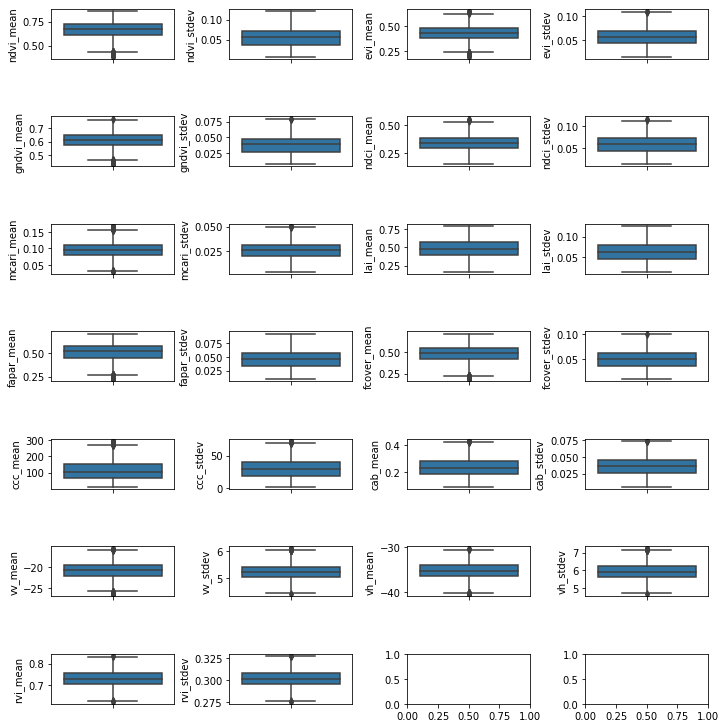

In [17]:
# implement function to filter out rows where predictor variable outside +- IQR * 1.5 ~ 3 stddevs
def filterOutliers( df, column ):

    # compute inter quantile range
    Q1 = df[ column ].quantile(0.25)
    Q3 = df[ column ].quantile(0.75)
    IQR = Q3 - Q1
    
    # filter values between Q1-1.5IQR and Q3+1.5IQR
    return df.query( f'(@Q1 - 1.5 * @IQR) <= {column} <= (@Q3 + 1.5 * @IQR)')

filtered = filterOutliers ( data, 'ndvi_mean' )
for col in cols:
    filtered = filterOutliers ( filtered, col )

getBoxPlots( filtered )
print ( len ( data ), len( filtered ) )

In [18]:
# take a random subset for regression analysis
subset = filtered.sample( int( len( filtered ) * 1.0 ) )
len( subset )

5368

### Visualise GEDI / Sentinel correlation matrix with outliers removed

<AxesSubplot:>

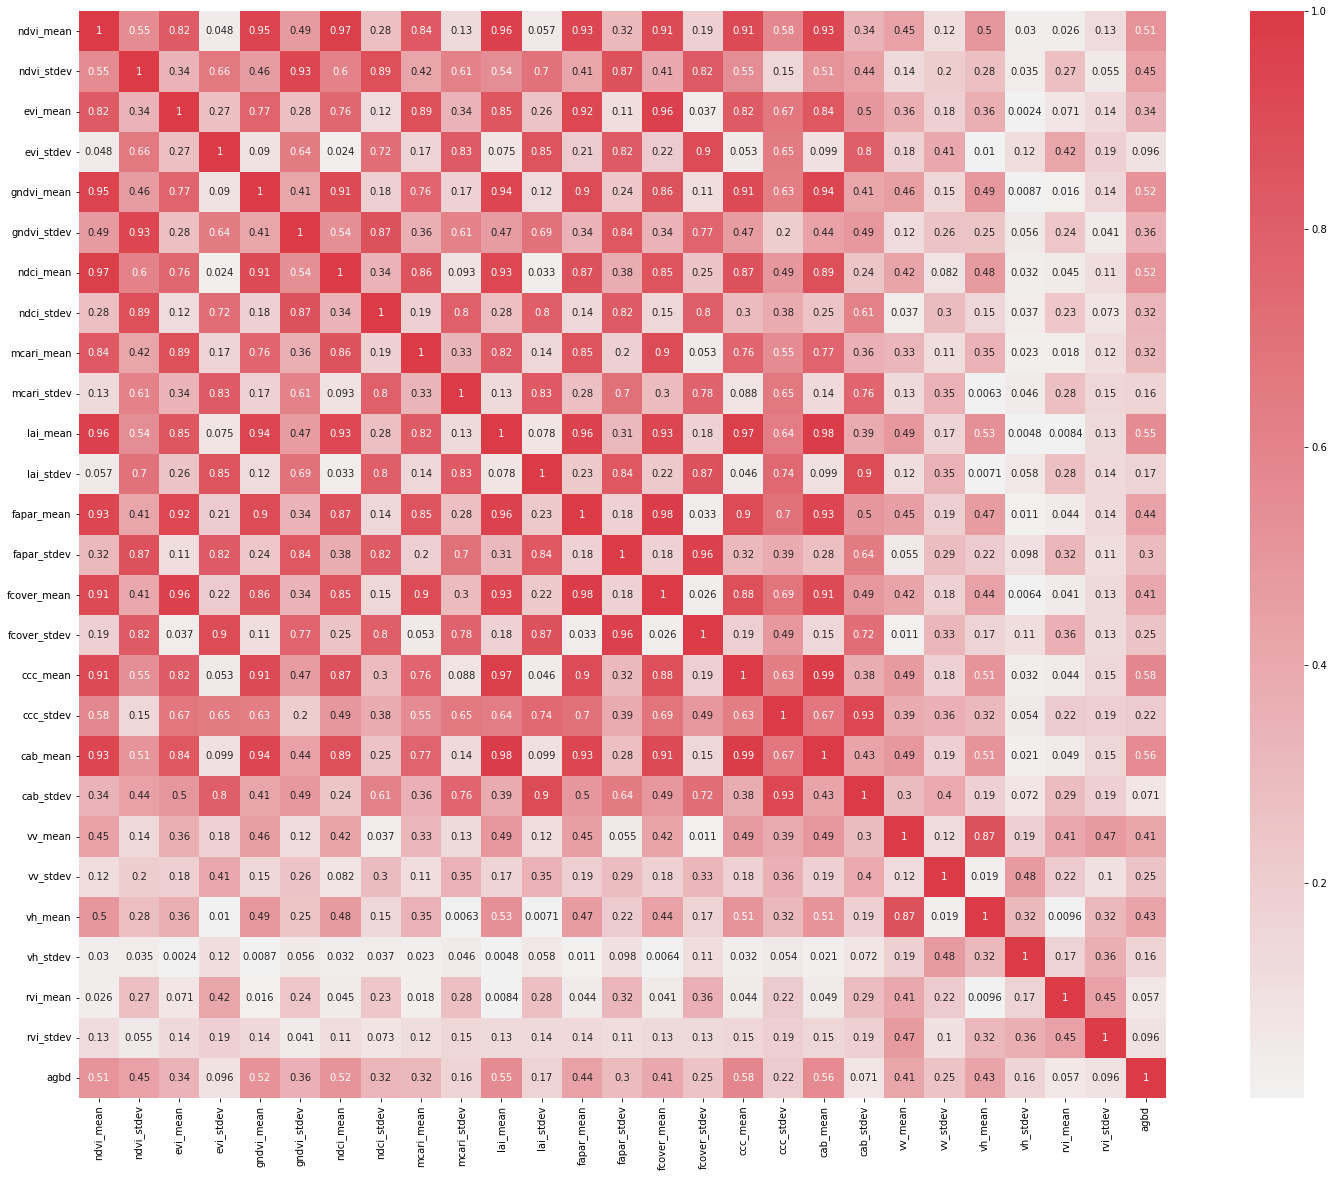

In [19]:
# plot correlation matrix
plt.figure( figsize=(30,20) )
cmap = sns.diverging_palette( 500, 10, as_cmap=True )
sns.heatmap( subset.corr().abs(), cmap=cmap, center=0, square=True, annot=True )

### Train XGBoost Regression model to estimate AGBD from Sentinel vegetation metrics

In [20]:
from sklearn.model_selection import train_test_split

# extract predictor matrix and target vector
target = subset[ 'agbd' ]
features = subset.drop( 'agbd', axis=1 )

# randomly split feature / target sample data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split( features, target, test_size=0.25 )
X_train.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,ccc_mean,ccc_stdev,cab_mean,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev
7187,0.763751,0.048352,0.412286,0.033757,0.663820,0.036229,0.422283,0.065000,0.109125,0.021289,...,137.160852,16.370898,0.259838,0.020122,-21.589326,5.453190,-34.790677,5.441429,0.769541,0.316642
587,0.624049,0.062451,0.413192,0.057561,0.582842,0.038632,0.290893,0.061104,0.084504,0.024765,...,85.145683,31.852889,0.204724,0.035538,-20.503225,5.144625,-36.352110,6.261122,0.685539,0.302599
7859,0.602907,0.063767,0.436867,0.063755,0.581854,0.044535,0.284714,0.058738,0.082585,0.027134,...,86.276328,33.377747,0.196867,0.046693,-18.678688,5.355802,-33.171092,5.827644,0.707327,0.292501
905,0.697613,0.048021,0.426750,0.049642,0.655419,0.037119,0.364803,0.060861,0.092868,0.024944,...,119.745767,35.703651,0.250067,0.042855,-19.804591,4.961627,-33.585833,5.484866,0.746055,0.300356
3826,0.560202,0.073664,0.373826,0.059032,0.538499,0.050694,0.240812,0.056326,0.065799,0.020195,...,52.838660,19.381528,0.168193,0.031865,-19.611881,5.358254,-35.088087,5.826603,0.660276,0.295538


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# create estimator pipeline
estimators = [ ('standardize', StandardScaler() ), 
               ('mlp', xgb.XGBRegressor( verbosity=1 ) ) ]

pipeline = Pipeline(estimators)

In [22]:
from sklearn.model_selection import GridSearchCV

# grid search space
"""
param_grid = {  'mlp__n_estimators': [400, 700, 1000],
                'mlp__colsample_bytree': [0.7, 0.8],
                'mlp__max_depth': [15,20,25],
                'mlp__reg_alpha': [1.1, 1.2, 1.3],
                'mlp__reg_lambda': [1.1, 1.2, 1.3],
                'mlp__subsample': [0.7, 0.8, 0.9]
}
"""

# define hyperparameter search space
param_grid = {  'mlp__n_estimators': [ 1800 ],
                'mlp__colsample_bytree': [ 0.7, 0.8 ],
                'mlp__max_depth': [ 30 ],
                'mlp__reg_alpha': [ 0.8, 1.0 ],
                'mlp__reg_lambda': [ 1.0, 1.3 ],
                'mlp__subsample': [ 0.7, 0.8 ]
}

# brute force cross validation across hyperparameter grid
gs = GridSearchCV(
        pipeline,
        param_grid=param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        verbose=1
    )

In [23]:
# determine optimal hyperparameter configuration against training data
best_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


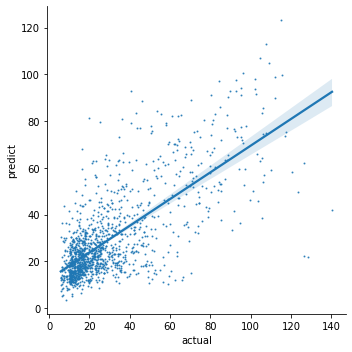

In [24]:
import seaborn as sns

# plot actual vs predicted test agbd values
result = pd.DataFrame( { 'actual' :  y_test.values, 'predict' : best_model.predict( X_test ) } )
sns.lmplot(x='actual',y='predict', data=result, fit_reg=True, scatter_kws={"s": 1 } ) 

In [25]:
# compute r2 between actual and predicted agbd
result[ 'actual' ].corr( result[ 'predict' ] )

0.7212752577901174

In [26]:
print(best_model.best_score_)
print(best_model.best_params_)

-246.2615448300929
{'mlp__colsample_bytree': 0.7, 'mlp__max_depth': 30, 'mlp__n_estimators': 1800, 'mlp__reg_alpha': 1.0, 'mlp__reg_lambda': 1.0, 'mlp__subsample': 0.8}
